<a href="https://colab.research.google.com/github/GianlucaCL/Proyecto_M7_GianlucaContenla/blob/main/UDD_Proyecto_M7_GianlucaContenla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bootcamp: Ciencia de Datos e Inteligencia Artificial**
## **Proyecto del Módulo 7: Técnicas avanzadas para ciencia de datos y empleabilidad**

Hola, ya es el último proyecto, has avanzado y aprendido mucho hasta acá. ¡Muchas felicidades!

Es hora de poner en práctica todo lo que hemos aprendido a lo largo de nuestra travesía.

Lee el proyecto y revisa con cuidado cada una de las instrucciones. Procura plasmar todo tu potencial para que lo concluyas de manera sobresaliente.

¡Éxito!

# Objetivos
- Aplicar con éxito todos los conocimientos que has adquirido a lo largo del Bootcamp.
- Consolidar las técnicas de limpieza, entrenamiento, graficación y ajuste a modelos de *Machine Learning*.
- Generar una API que brinde predicciones como resultado a partir de datos enviados.


# Proyecto

1. Selecciona uno de los siguientes *datasets*:
  - Imágenes de rayos X de pecho para detectar neumonía: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
  - *Reviews* de aplicaciones de la Google Play Store: https://www.kaggle.com/datasets/lava18/google-play-store-apps
  - Estadísticas demográficas de los ganadores del premio Oscar de la Academia: https://www.kaggle.com/datasets/fmejia21/demographics-of-academy-awards-oscars-winners
  - Aspiraciones profesionales de la generación Z: https://www.kaggle.com/datasets/kulturehire/understanding-career-aspirations-of-genz

Cada uno representa un *dataset*, un problema y una forma diferente de abordarlo. Tu tarea es identificar las técnicas y modelos que podrías usar para tu proyecto.

2. Debes hacer un análisis exploratorio y limpieza de los datos. Usa las ténicas que creas convenientes.

3. Entrena el modelo de *Machine Learning*, procesamiento de lenguaje natural o red neuronal que creas adecuado.

4. Genera por lo menos dos gráficas y dos métricas de rendimiento; explica las puntuaciones de rendimiento que amerite tu problema. Todas las gráficas de rendimiento que realices deben tener leyendas, colores y títulos personalizados por ti.

  - Además, antes de subir el modelo a "producción", deberás realizar un proceso de ensambles (*ensemblings*) y de ajuste de hiperparámetros o *tuning* para intentar mejorar la precisión y disminuir la varianza de tu modelo.

5. Construye una API REST en la que cualquier usuario pueda mandar datos y que esta misma devuelva la predicción del modelo que has hecho. La API debe estar en la nube, ya sea en un servicio como Netlify o Ngrok, para que pueda ser consultada desde internet.

6. Genera una presentación del problema y del modelo de solución que planteas. Muestra gráficas, datos de rendimiento y explicaciones. Esta presentación debe estar enfocada a personas que no sepan mucho de ciencia de datos e inteligencia artificial.

7. **Solamente se recibirán trabajos subidos a tu cuenta de GitHub con un README.md apropiado que explique tu proyecto**.

## Criterios de evaluación

| Actividad | Porcentaje | Observaciones | Punto parcial
| -- | -- | -- | -- |
| Actividad 1. Limpieza y EDA | 20 | Realiza todas las tareas necesarias para hacer el EDA y la limpieza correcta, dependiendo de la problemática. Debes hacer como mínimo el análisis de completitud, escalamiento (si aplica) y tokenización (si aplica). | Realizaste solo algunas tareas de exploración y limpieza y el modelo se muestra aún con oportunidad de completitud, escalamiento y/o mejora. |
| Actividad 2. Entrenamiento del modelo | 20 | Elige el modelo y algoritmo adecuados para tu problema, entrénalo con los datos ya limpios y genera algunas predicciones de prueba. | No has realizado predicciones de prueba para tu modelo de ML y/o tu modelo muestra una precisión menor al 60 %. |
| Actividad 3. Graficación y métricas | 20 | Genera por lo menos dos gráficas y dos muestras de métricas que permitan visualizar el rendimiento y precisión del modelo que construiste. Además, realizaste los procesos de *tuning* y ensambles adecuados para tu problema. | Las gráficas no tienen leyendas y colores customizados, solo muestras una gráfica o no realizaste el *tuning* de hiperparámetros.
| Actividad 4. API REST | 20 | Generaste con éxito un *link* público en el que, por método POST, se puede mandar información y la API REST devuelve una predicción junto con el porcentaje de confianza de esta misma. | N/A
| Actividad 5. Presentación | 20 | Genera una presentación en la que establezcas como mínimo: el problema, proceso de solución, metodologías usadas, gráficas de rendimiento, demostración del modelo y aprendizajes obtenidos. Debes redactarla con términos que pueda entender cualquier persona, no solo científicos de datos. | La presentación no expone con claridad o en términos coloquiales el proceso de creación del modelo, sus ventajas y muestras de rendimiento.

**Mucho éxito en tu camino como Data Scientist.**

In [26]:
# ## Configuración Inicial
!pip install -q keras-tuner flask-ngrok
!pip install -q tensorflow==2.12.0

In [27]:
#Montaje y drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import cv2
import tempfile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


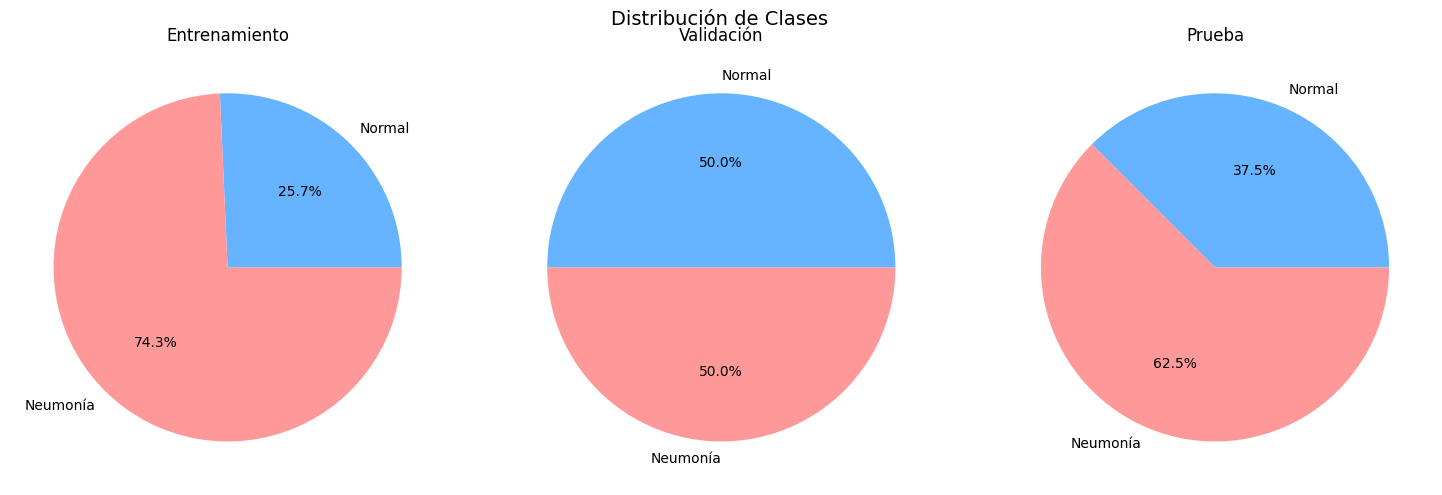

In [28]:
# Análisis exploratorio de datos y preparación.

#rutas
base_path = '/content/drive/MyDrive/CSVs/chest_xray'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')
val_dir = os.path.join(base_path, 'val')

#funcion para analizar la distribución
def plot_class_distribution():
    def count_files(directory):
        return [len(os.listdir(os.path.join(directory, cls))) for cls in ['NORMAL', 'PNEUMONIA']]

    train_counts = count_files(os.path.join(train_dir))
    val_counts = count_files(os.path.join(val_dir))
    test_counts = count_files(os.path.join(test_dir))

    plt.figure(figsize=(15, 5))
    plt.suptitle('Distribución de Clases', fontsize=14)

    plt.subplot(1, 3, 1)
    plt.pie(train_counts, labels=['Normal', 'Neumonía'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
    plt.title('Entrenamiento')

    plt.subplot(1, 3, 2)
    plt.pie(val_counts, labels=['Normal', 'Neumonía'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
    plt.title('Validación')

    plt.subplot(1, 3, 3)
    plt.pie(test_counts, labels=['Normal', 'Neumonía'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
    plt.title('Prueba')

    plt.tight_layout()
    plt.show()

plot_class_distribution()

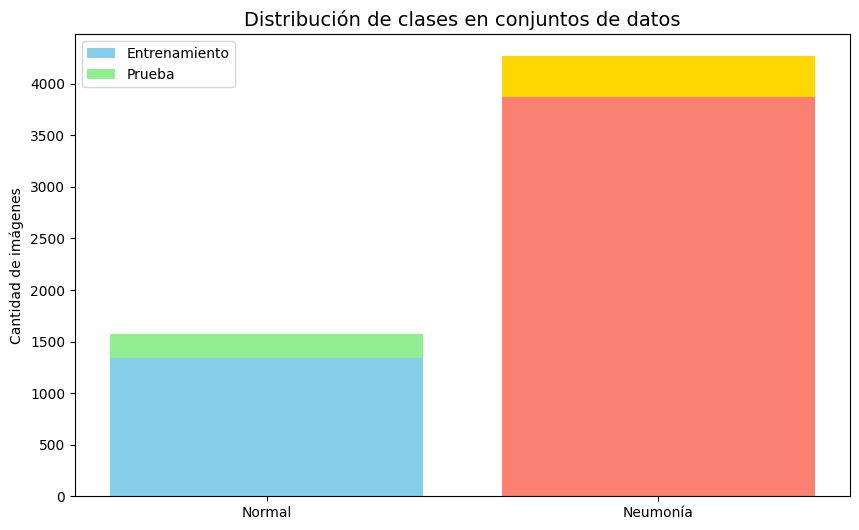

In [29]:
#más visualización
def count_files(directory):
    normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal, pneumonia

train_norm, train_pneu = count_files(train_dir)
test_norm, test_pneu = count_files(test_dir)
val_norm, val_pneu = count_files(val_dir)

plt.figure(figsize=(10, 6))
categories = ['Normal', 'Neumonía']
train_counts = [train_norm, train_pneu]
test_counts = [test_norm, test_pneu]

plt.bar(categories, train_counts, color=['skyblue', 'salmon'], label='Entrenamiento')
plt.bar(categories, test_counts, bottom=train_counts, color=['lightgreen', 'gold'], label='Prueba')
plt.title('Distribución de clases en conjuntos de datos', fontsize=14)
plt.ylabel('Cantidad de imágenes')
plt.legend()
plt.show()

**Hay más datos de neuomía que normales, lo que podría favorecer al con más datos. Entrenaré más el modelo para compensar**

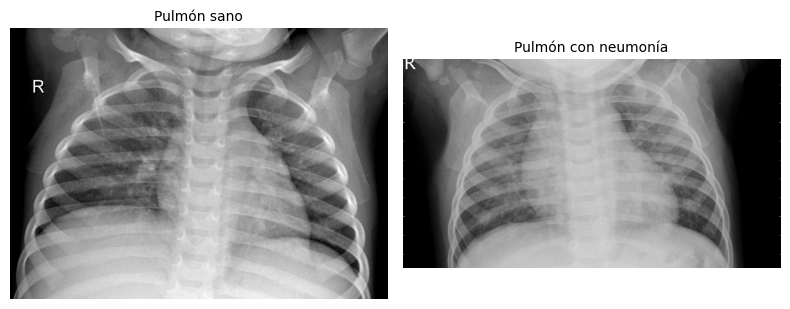

In [49]:
#visualización de imágenes
def load_sample_images(path):
    norm_img = plt.imread(os.path.join(path, 'NORMAL', os.listdir(os.path.join(path, 'NORMAL'))[0]))
    pneu_img = plt.imread(os.path.join(path, 'PNEUMONIA', os.listdir(os.path.join(path, 'PNEUMONIA'))[0]))
    return norm_img, pneu_img

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(load_sample_images(train_dir)[0], cmap='gray')
plt.title('Pulmón sano', fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(load_sample_images(train_dir)[1], cmap='gray')
plt.title('Pulmón con neumonía', fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
#preprocesamiento de datos

#parámetros
IMG_SIZE = 150 #tuve que bajar un poco la imagen y limitar el batch size ya que estuve experimentando bastante con el Colab Pro y ya casi se me agotan los créditos de unidades de procesamiento.
BATCH_SIZE = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2])

val_test_datagen = ImageDataGenerator(rescale=1./255)

#genero datos
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [32]:
# Entrenamiento del modelo

def build_model(hp):
    model = Sequential()

    #capas convolucionales
    model.add(Conv2D(
        hp.Int('conv1_units', 32, 128, step=32),
        (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5)))

    model.add(Conv2D(
        hp.Int('conv2_units', 64, 256, step=64),
        (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5)))

    model.add(Flatten())

    #densas
    model.add(Dense(
        hp.Int('dense_units', 128, 512, step=128),
        activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout', 0.1, 0.5)))

    model.add(Dense(1, activation='sigmoid'))

    #optimización de hiperparámetros
    optimizer = Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

#búsqueda de hiperparámetros
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='tuning',
    project_name='pneumonia_detection')

tuner.search(train_generator,
             epochs=12,
             validation_data=val_generator,
             callbacks=[EarlyStopping(patience=3)])

Reloading Tuner from tuning/pneumonia_detection/tuner0.json


In [33]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ],
    class_weight={0: 1.0, 1: 0.6}
)

Epoch 1/12
163/163 [==============================] - 143s 811ms/step - loss: 0.2780 - accuracy: 0.8370 - precision: 0.9168 - recall: 0.8586 - val_loss: 0.4827 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/12
163/163 [==============================] - 132s 807ms/step - loss: 0.2484 - accuracy: 0.8497 - precision: 0.9268 - recall: 0.8661 - val_loss: 0.5399 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/12
163/163 [==============================] - 131s 801ms/step - loss: 0.2328 - accuracy: 0.8633 - precision: 0.9384 - recall: 0.8733 - val_loss: 0.4578 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/12
163/163 [==============================] - 134s 805ms/step - loss: 0.2144 - accuracy: 0.8744 - precision: 0.9438 - recall: 0.8836 - val_loss: 0.4538 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/12
163/163 [==============================] - 131s 802ms/step - loss: 0.2071 - a

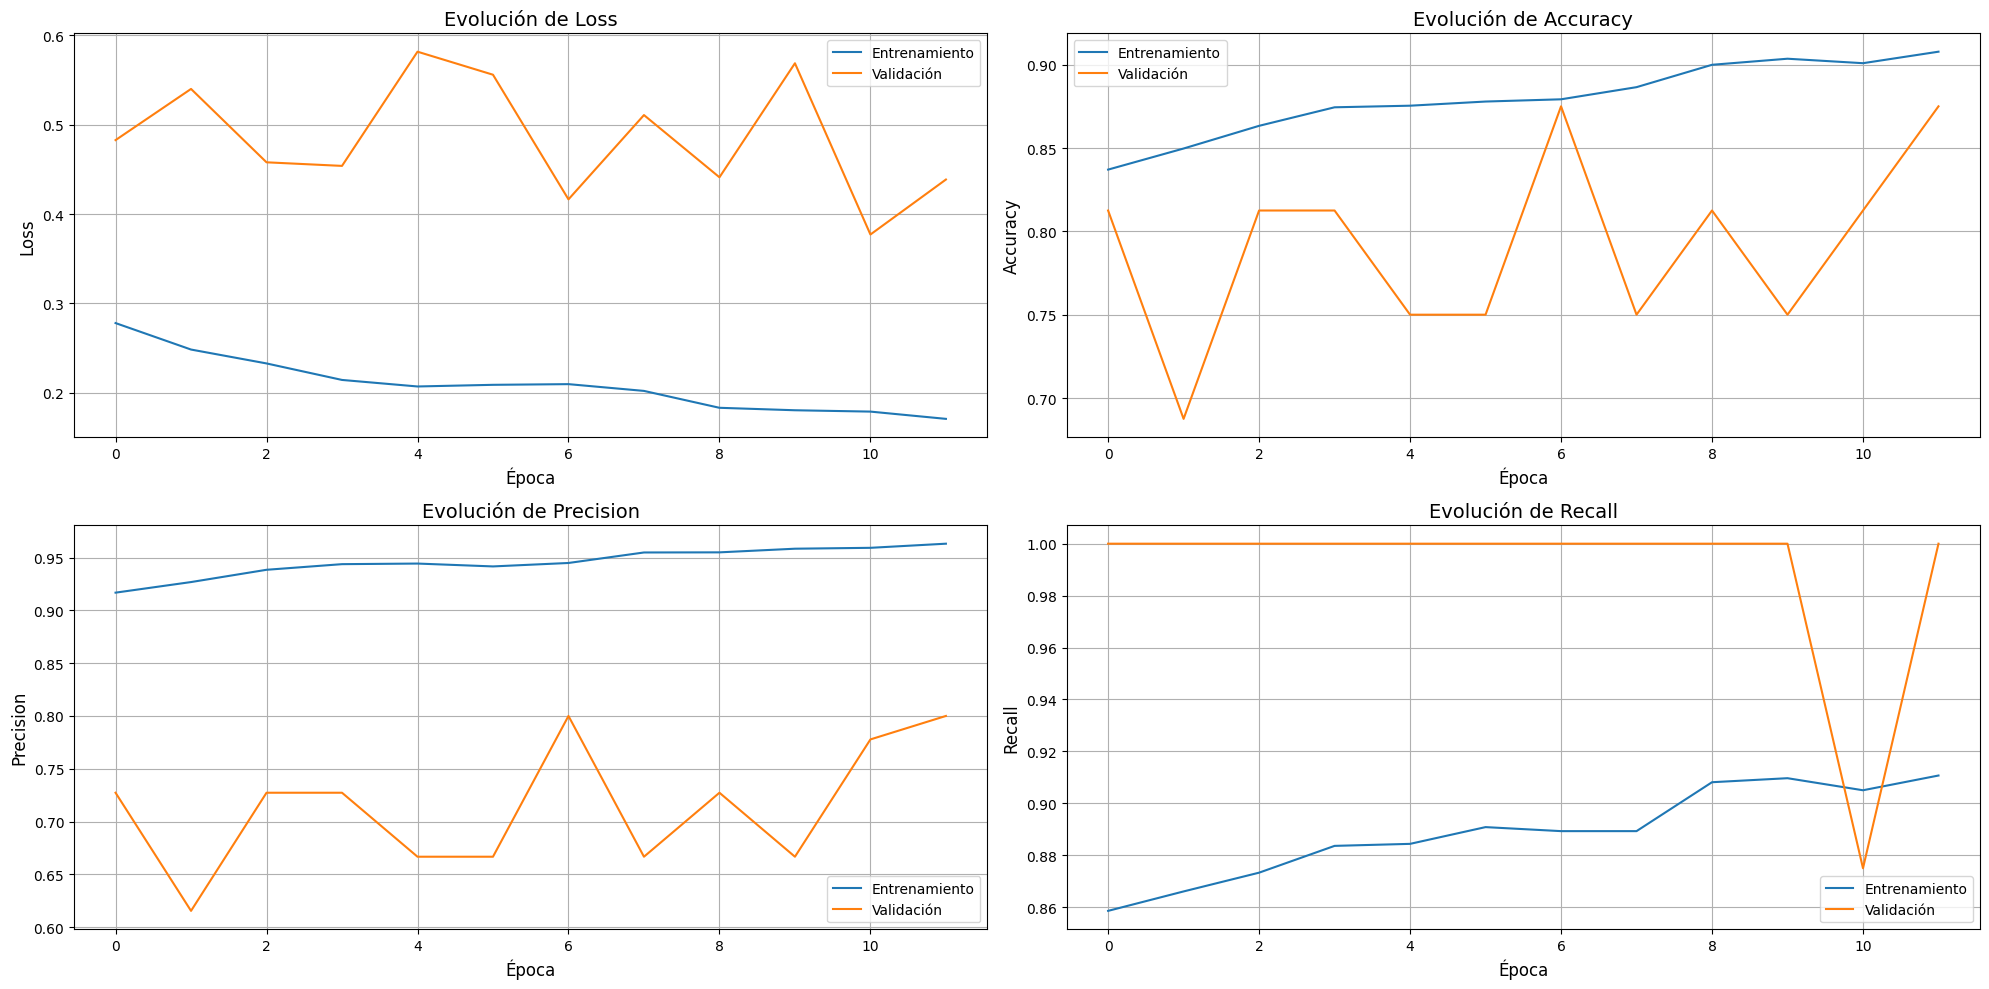

In [34]:
#Evaluación del modelo y visualización con métricas
def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(20,10))

    for i, metric in enumerate(metrics):
        plt.subplot(2,2,i+1)
        plt.plot(history.history[metric], label='Entrenamiento')
        plt.plot(history.history[f'val_{metric}'], label='Validación')
        plt.title(f'Evolución de {metric.capitalize()}', fontsize=14)
        plt.xlabel('Época', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [45]:
#Quise hacer un F1 también.
f1_scores = []
for i in range(len(history.history['precision'])):
    precision = history.history['precision'][i]
    recall = history.history['recall'][i]
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Evitar el error de divided by zero
    f1_scores.append(f1)

history.history['f1_score'] = f1_scores

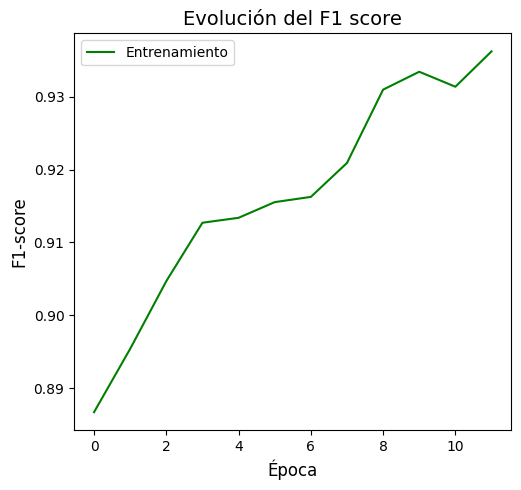

In [47]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1_score'], label='Entrenamiento', color='green')
    plt.title('Evolución del F1 score', fontsize=14)
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('F1-score', fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

20/20 [==============================] - 7s 299ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.82      0.87      0.84       234
    Neumonía       0.92      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.87       624
weighted avg       0.88      0.88      0.88       624



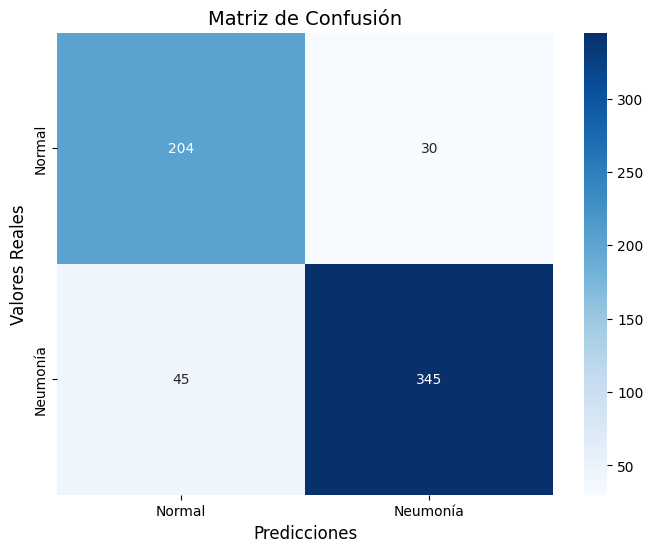

In [35]:
#visualización de matriz
y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.5).astype(int)

print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Neumonía']))

plt.figure(figsize=(8,6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Neumonía'],
            yticklabels=['Normal', 'Neumonía'])
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Valores Reales', fontsize=12)
plt.show()

**Se obtuvo casi un 90% de precisión, lo que indica que es un buen modelo.**

Predicciones en el conjunto de prueba:
1/1 [==============================] - 0s 162ms/step


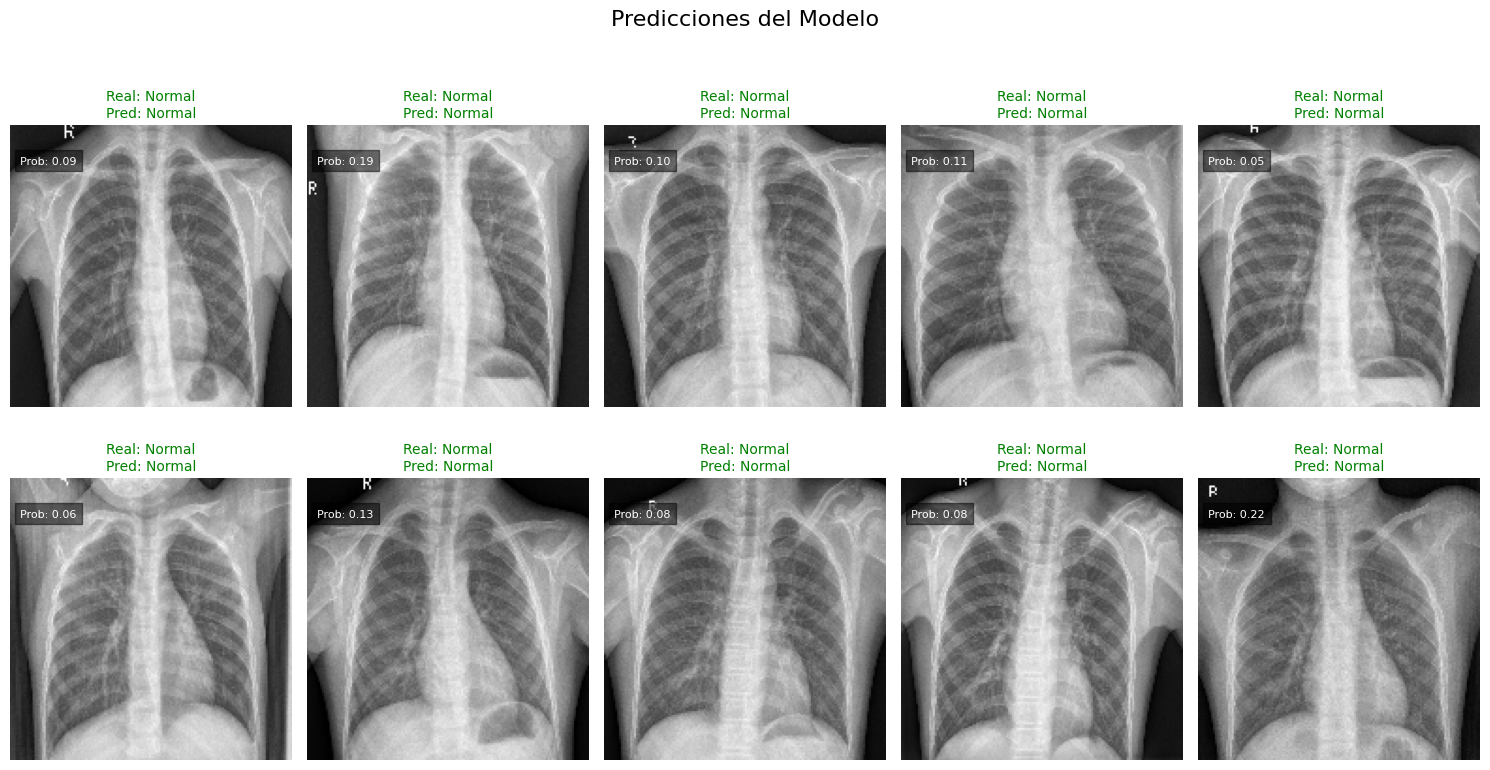

In [36]:
# Prueba del modelo, aquí comparo que el modelo efectivamente haga una predicción correcta.

def plot_predictions(model, generator, num_samples=10):
    #se obtienen las imágenes
    test_images, true_labels = next(generator)

    #Predicciones
    predictions = model.predict(test_images)
    predicted_labels = (predictions > 0.5).astype(int)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Predicciones del Modelo', fontsize=16, y=1.02)

    for i in range(min(num_samples, len(test_images))):
        plt.subplot(2, 5, i+1)

        plt.imshow(test_images[i], cmap='gray')

        #cuando es correcta la predicción será verde, sino rojo
        true_label = 'Normal' if true_labels[i] == 0 else 'Neumonía'
        pred_label = 'Normal' if predicted_labels[i] == 0 else 'Neumonía'

        if true_label == pred_label:
            title_color = 'green'
        else:
            title_color = 'red'

        plt.title(f"Real: {true_label}\nPred: {pred_label}",
                 color=title_color, fontsize=10)

        # Mostrar probabilidad
        plt.text(5, 20, f"Prob: {predictions[i][0]:.2f}",
                color='white', fontsize=8,
                bbox=dict(facecolor='black', alpha=0.5))

        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Predicciones en el conjunto de prueba:")
plot_predictions(best_model, test_generator, num_samples=10)

**El modelo obtuvo 10/10, por lo que reafirma que es un modelo preciso**

In [37]:
#API REST con Flask

app = Flask(__name__)
run_with_ngrok(app)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return np.expand_dims(img, axis=0)

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No se proporcionó imagen'}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'Nombre de archivo vacío'}), 400

    try:
        with tempfile.NamedTemporaryFile(delete=False) as tmp:
            file.save(tmp.name)
            processed_img = preprocess_image(tmp.name)
            prediction = best_model.predict(processed_img)[0][0]

        return jsonify({
            'prediccion': float(prediction),
            'diagnostico': 'Neumonía' if prediction > 0.5 else 'Normal',
            'confianza': float(prediction if prediction > 0.5 else 1 - prediction)
        })
    except Exception as e:
        return jsonify({'error': str(e)}), 500

In [48]:
#Ejecución de la API, aquí te da el URL

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-102:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
          

In [39]:
#guardo modelo
best_model.save('/content/drive/MyDrive/CSVs/pneumonia_model.h5')